# Tree Classifier

**Import dependencies**

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

**Import and configure dataset**

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
column_names = [
    "A1",
    "A2",
    "A3",
    "A4",
    "A5",
    "A6",
    "A7",
    "A8",
    "A9",
    "A10",
    "A11",
    "A12",
    "A13",
    "A14",
    "A15",
    "A16",
]
data = pd.read_csv(url, header=None, names=column_names, na_values="?")
data = pd.get_dummies(
    data, columns=["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
)

print(data.head())
print(data.info())
print(data.isnull().sum())

# unique values in categorical features
print(data.select_dtypes(include="object").nunique())

      A2     A3    A8  A11    A14  A15 A16   A1_a   A1_b   A4_l  ...   A7_z  \
0  30.83  0.000  1.25    1  202.0    0   +  False   True  False  ...  False   
1  58.67  4.460  3.04    6   43.0  560   +   True  False  False  ...  False   
2  24.50  0.500  1.50    0  280.0  824   +   True  False  False  ...  False   
3  27.83  1.540  3.75    5  100.0    3   +  False   True  False  ...  False   
4  20.17  5.625  1.71    0  120.0    0   +  False   True  False  ...  False   

    A9_f  A9_t  A10_f  A10_t  A12_f  A12_t  A13_g  A13_p  A13_s  
0  False  True  False   True   True  False   True  False  False  
1  False  True  False   True   True  False   True  False  False  
2  False  True   True  False   True  False   True  False  False  
3  False  True  False   True  False   True   True  False  False  
4  False  True   True  False   True  False  False  False   True  

[5 rows x 47 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 47 columns):
 

**Feature engineering**

In [3]:
data["TotalIncome"] = data["A11"] + data["A15"]
scaler = StandardScaler()
data[["A2", "A3", "A8", "A11", "A14", "A15", "TotalIncome"]] = scaler.fit_transform(
    data[["A2", "A3", "A8", "A11", "A14", "A15", "TotalIncome"]]
)

**Separate features (X) and labels (y)**

In [4]:
X = data.drop("A16", axis=1)
y = data["A16"]

**Split the data into training, validation, and test sets**

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

**Pipeline for filling in missing values and scaling features**

In [6]:
pipeline = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

**Train base model**

In [7]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**Evaluate accuracy on the validation set**

In [8]:
y_val_pred = dt_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on the validation set: {accuracy_val:.4f}")

Accuracy on the validation set: 0.7961


**Define parameters for grid search and find best esimator**

In [9]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"The best hyperparameters:\n{grid_search.best_params_}")
print(f"Accuracy on the validation set:\n{grid_search.best_score_}")
y_test_pred = grid_search.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {accuracy_test:.4f}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}")

The best hyperparameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on the validation set:
0.8507731958762887
Accuracy on the test set: 0.7885
Classification report:
              precision    recall  f1-score   support

           +       0.78      0.74      0.76        47
           -       0.80      0.82      0.81        57

    accuracy                           0.79       104
   macro avg       0.79      0.78      0.79       104
weighted avg       0.79      0.79      0.79       104


**Visualization**

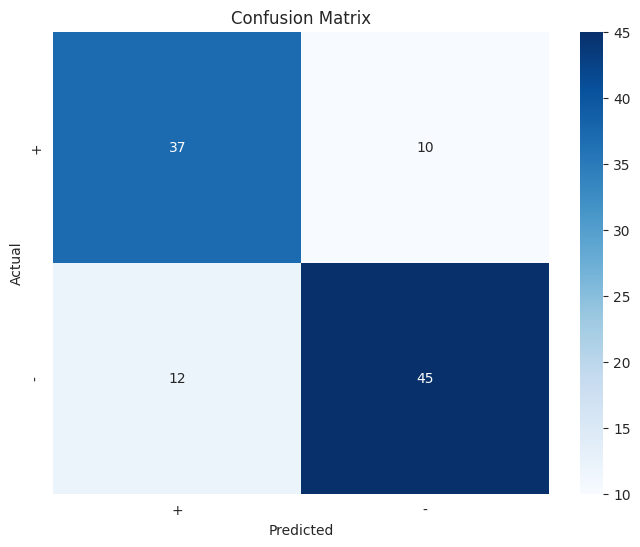

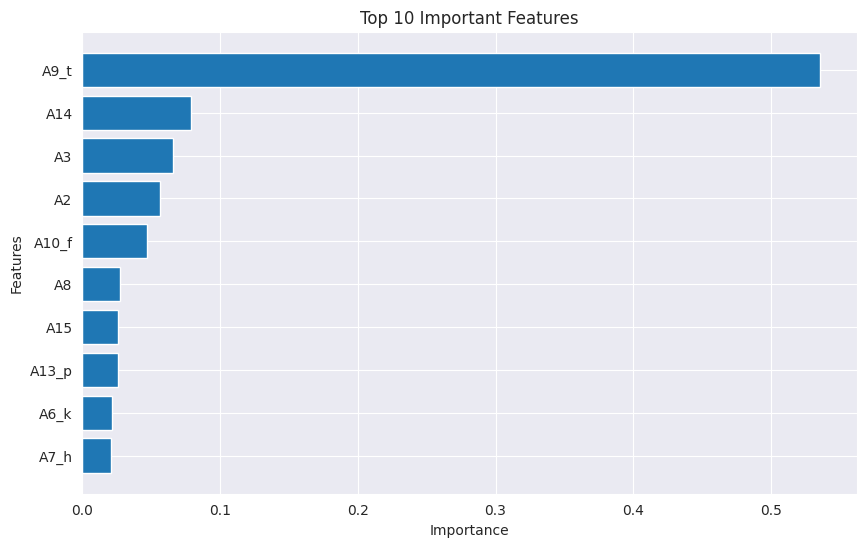

In [10]:
y_test_pred = dt_classifier.predict(X_test)

confusion_matrix = pd.crosstab(
    y_test, y_test_pred, rownames=["Actual"], colnames=["Predicted"]
)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()

feature_importance = dt_classifier.feature_importances_
features = X.columns
sorted_idx = feature_importance.argsort()

num_features = 10

plt.figure(figsize=(10, 6))
plt.barh(
    range(num_features), feature_importance[sorted_idx][-num_features:], align="center"
)
plt.yticks(range(num_features), [features[i] for i in sorted_idx][-num_features:])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features")
plt.show()